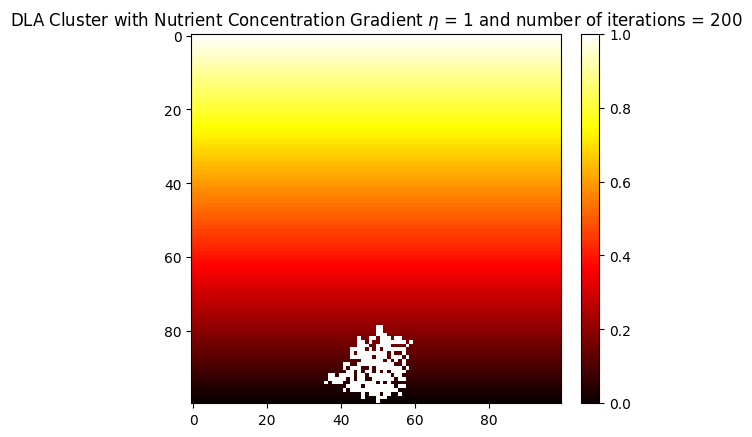

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
size = 100  # Size of the domain
seed_position = (size - 1, size // 2)  # Seed at the bottom center
eta = 1  # Shape parameter
iterations = 200  # Number of growth steps
omega = 1.9  # Over-relaxation parameter
epsilon = 1e-5  # epsilon for SOR convergence

# Initialize domain
domain = np.zeros((size, size))
domain[seed_position] = 1  # Place the initial seed

# Initialize the nutrient concentration grid with highest concentration at the top
concentration = np.linspace(1, 0, size).reshape(-1, 1)  # Gradient from top (1) to bottom (0)
concentration = np.tile(concentration, (1, size))  # Extend the gradient horizontally

# Function to find growth candidates
def find_growth_candidates(domain):
    candidates = []
    for i in range(1, domain.shape[0] - 1):
        for j in range(1, domain.shape[1] - 1):
            if domain[i, j] == 0 and np.any(domain[i-1:i+2, j-1:j+2] == 1):
                candidates.append((i, j))
    return candidates

# SOR method to solve the Laplace equation
def solve_laplace(concentration, domain, omega, epsilon):
    theta = np.inf  # Initialize theta to be larger than epsilon
    while theta > epsilon:
        max_change = 0
        for i in range(1, size - 1):
            for j in range(1, size - 1):
                if domain[i, j] == 0:  # Update only if not part of the cluster
                    old_value = concentration[i, j]
                    concentration[i, j] = (omega / 4) * (concentration[i+1, j] + concentration[i-1, j] + concentration[i, j+1] + concentration[i, j-1]) + (1 - omega) * old_value
                    max_change = max(max_change, np.abs(concentration[i, j] - old_value))
        theta = max_change
    return concentration

# Growth function
def grow(domain, concentration, omega, eta):
    concentration = solve_laplace(concentration, domain, omega, epsilon)
    candidates = find_growth_candidates(domain)
    if not candidates:
        return domain, concentration  # No more growth possible

    probabilities = [concentration[i, j] ** eta for i, j in candidates]
    probabilities /= np.sum(probabilities)

    # Select and add new growth site
    growth_site = candidates[np.random.choice(len(candidates), p=probabilities)]
    domain[growth_site] = 1
    return domain, concentration

# Simulation function
def sim(domain, concentration, omega, iterations, eta):
    for _ in range(iterations):
        domain, concentration = grow(domain, concentration, omega, eta)
    return domain, concentration

# Run the simulation
final_domain, final_concentration = sim(domain, concentration, omega, iterations, eta)

# Visualization
fig, ax = plt.subplots()
cmap = ax.imshow(final_concentration, cmap='hot', interpolation='nearest')
fig.colorbar(cmap, ax=ax, fraction=0.046, pad=0.04)
cluster_overlay = np.ma.masked_where(final_domain == 0, final_domain)
ax.imshow(cluster_overlay, cmap='Greys', interpolation='nearest')
ax.set_title(f'DLA Cluster with Nutrient Concentration Gradient $\eta$ = {eta} and number of iterations = {iterations}')
plt.show()
